In [ ]:
#Diseñar un algoritmo que sea capaz de detectar y dibujar automaticamente las rectas.
 
#Extraer la posicion de las lineas exteriores y la linea central de la cancha en la imagen
#Primero: Eliminar ruido 
#Segundo: Tecnica de busqueda y ajuste de lineas en la imagen. RANSAC, Hough o barrido horizontal o vertical. SOLO SE PERMITE UTILIZAR FUNCIONES PARA RESOLVER SISTEMAS POR MINIMOS CUADRADOS
#Tercero: Non-Max-Suppressio, elegir entre detecciones multiples de la misma recta y definir una deteccion unica entre lineas -analizar el angulo entre las rectas-.

In [3]:
! pip install ../cvum
import cv2
import numpy as np
from cvum.utils import add_snp_noise
from cvum.utils import imread_rgb
from cvum.utils import correlationdot_2D
from sympy.solvers import solve
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

Processing c:\users\juana\onedrive\documents\facultad\cv\cv-um-2021\cvumProcessing c:\users\juana\onedrive\documents\facultad\cv\cv-um-2021\cvum
  Created wheel for cvum: filename=cvum-0.0.1-py3-none-any.whl size=2880 sha256=6b45cf159dcb8bfd1e8408ebac43cfbc56835a6bb2f485b75c7cf29ab85b786b
  Stored in directory: C:\Users\juana\AppData\Local\Temp\pip-ephem-wheel-cache-t4o7dpag\wheels\05\e1\99\ab5753deff9f28d2f740e2673713ba35182f089b10d9054479
Successfully built cvum

  Created wheel for cvum: filename=cvum-0.0.1-py3-none-any.whl size=2880 sha256=6b45cf159dcb8bfd1e8408ebac43cfbc56835a6bb2f485b75c7cf29ab85b786b
  Stored in directory: C:\Users\juana\AppData\Local\Temp\pip-ephem-wheel-cache-d28o2zc4\wheels\05\e1\99\ab5753deff9f28d2f740e2673713ba35182f089b10d9054479
Successfully built cvum


[[[193.          1.5184364]]

 [[191.          1.5184364]]]
[INFO] angulo: -3.00000


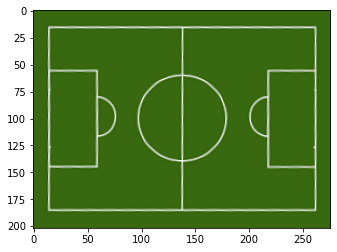

In [4]:
#Enderezar img

img = cv2.imread('./images/football.png') #Cargamos imagen


def estan_cercanos(a1, a2, error):
    cases = np.unwrap([a2-error, a1, a2 + error])
    return cases[0] <= cases[1] <= cases[2]

def enderezar(entrada, salida):
    # Leer la imagen
    imagen = cv2.imread(entrada)

    # Convertirla a gris y detectar bordes
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    binaria = cv2.Canny(gray,50,150,apertureSize = 3)
    # Usar la transformada de Hough para encontrar líneas
    # en la imagen binarizada, con una resolución de medio
    # grado (pi/720) y quedándose sólo con las líneas que
    # alcancen puntuación de 1000 o más (que serán las
    # más largas)
    lineas = cv2.HoughLines(binaria, 1, np.pi/720, 200)
    print(lineas)
    # Recopilemos qué ángulos ha encontrado la transformada
    # de hough para cada una de las líneas halladas
    angulos = []
    for linea in lineas:
        rho, theta = linea[0]
        if rho<0:
            theta = -theta

        # Quedarse solo con las rayas próximas a la horizontal
        # (con un error de +-10 grados)
        if not estan_cercanos(theta, np.pi/2, np.deg2rad(10)):
           continue;

        angulos.append(theta)

    # Ahora contemos cuántas veces aparece cada ángulo
    from collections import Counter
    veces = Counter(angulos)

    # Quedémonos con los tres casos más frecuentes
    frecuentes = veces.most_common(3)

    # Y calculemos el promedio de esos tres casos
    suma = sum(angulo*repeticion for angulo,repeticion in frecuentes)
    repeticiones = sum(repeticion for angulo, repeticion in frecuentes)
    angulo = suma/repeticiones

    angulo = np.rad2deg(angulo - np.pi/2)
    print("[INFO] angulo: {:.5f}".format(angulo))

    # Ahora enderecemos la imagen, girando el ángulo detectado
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)

    girada = cv2.warpAffine(imagen, M, (w, h),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Y volcamos a disco el resultado
    cv2.imwrite(salida, girada)

    plt.imshow(girada)



    
enderezar('./images/football.png','./images/derecha.png')


In [ ]:
#Luego de tener la imagen recta, hay que detectar lineas, primero eliminamos ruido

5
[{x: 259, y: 17}, {x: 136, y: 17}, {x: 13, y: 17}, {x: 259, y: 183}, {x: 136, y: 183}, {x: 13, y: 183}]


True

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

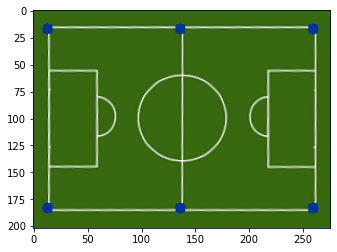

In [5]:
#@title Default title text
img = cv2.imread('./images/derecha.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 7
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 360  # angular resolution in radians of the Hough grid
threshold = 8  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 160  # minimum number of pixels making up a line
max_line_gap = 3  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
from sympy import symbols, solveset, Eq
x, y = symbols('x y')
i=0
ecuations = [1]*len(lines)
#fig=plt.figure(figsize=(10, 1))
#array_x = [1]*len(lines)
#array_y = [1]*len(lines)
print(len(lines))
for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
      #ecuations[i] = ((x-x1)*(y2-y1))/(x2-x1) + y1 - y
      plt.figure()
      #plt.imshow(line_image)
      val = (x2 - x1)
      if ((x2 - x1)==0):
        ecuations[i] = x - x1
        #array_x[i] = Eq(x - x1)
        #print(array_x[i])
      else:
        ecuations[i] = ((x-x1)*(y2-y1))/(x2-x1) + y1 - y#x*(y2/val) -x*(y1/val) - x1*(y2/val) + x1*(y1/val) + y1 - y
        #array_y[i] = Eq(((x-x1)*(y2-y1))/(x2-x1) + y1 - y)
        #print(array_y[i])
      i += 1

img_derecha = cv2.imread('./images/derecha.png')
points=[]
for e in range(0,len(ecuations)):
    for f in range(e+1,len(ecuations)):
        #sol = sym.Eq(ecuations[e],ecuations[f])
        sol = solve([ecuations[e], ecuations[f]])
        if sol:
          points.append(sol)
          line_pointers = cv2.circle(img_derecha, (sol[x],sol[y]), radius=5, color=(0, 51, 153), thickness=-1)
    

cv2.imwrite('./images/puntos.png', line_pointers)
plt.imshow(line_pointers)
print(points)







#print(ecuations)
#for j in range(0,len(ecuations)):
    #sol = solveset((ecuations[j], ecuations[j+1]),(x, y))
    #print(sol)
#print(ecuations)
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
cv2.imwrite('./images/lines.png', lines_edges)
#plt.imshow(lines_edges)



